# This is a notebook for the New York City Taxi Fare Prediction Playground Competition 
Here we'll use a Gradient Boosting Regressor model which is a common winner for most Kaggle competitions to predict the `fare_amount` of each ride.

This kernel uses some `sklearn`, `pandas`, `numpy`, and `matplotlib` for the critical work.

In [25]:
# Initial Python environment setup...
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to
import matplotlib.pyplot as plt #data viz.
import seaborn as sb #data viz.
from sklearn.ensemble import GradientBoostingRegressor #ML algorithm
from sklearn.linear_model import LinearRegression #ML algorithm
from sklearn.model_selection import train_test_split #splitting dataset
from sklearn.metrics import mean_squared_error

%matplotlib inline

print(os.listdir('/Users/hthakkar/Desktop/fare_price_preds'))

['.DS_Store', 'test.csv', 'GCP-Coupons-Instructions.rtf', 'train.csv', 'sample_submission.csv']


### Setup training data
First let's read in our training data.  My system doesn't yet support enough memory to load the whole dataset of 55M rows at once, at least using `pd.read_csv` --so we're skipping a good portion of the data, but it's certainly possible to build a model using all the data.

In [26]:
train_df =  pd.read_csv('/Users/hthakkar/Desktop/fare_price_preds/train.csv', nrows = 20_000_000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [27]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [28]:
train_df['key'] = pd.to_datetime(train_df['key'], format= '%Y/%m/%d %H:%M:%S', exact= True)
train_df['pickup_datetime']  = train_df.pickup_datetime.str[:20]
train_df['pickup_datetime']  = pd.to_datetime(train_df['pickup_datetime'], format = '%Y/%m/%d %H:%M:%S')

In [29]:
train_df.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [30]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [31]:
train_df.describe().round(1)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,20000000.0,20000000.0,20000000.0,19999861.0,19999861.0,20000000.0
mean,11.3,-72.5,39.9,-72.5,39.9,1.7
std,16.9,13.0,9.4,12.9,9.6,1.3
min,-107.8,-3439.2,-3492.3,-3442.0,-3493.7,0.0
25%,6.0,-74.0,40.7,-74.0,40.7,1.0
50%,8.5,-74.0,40.8,-74.0,40.8,1.0
75%,12.5,-74.0,40.8,-74.0,40.8,2.0
max,61550.9,3457.6,3406.0,3457.6,3400.4,208.0


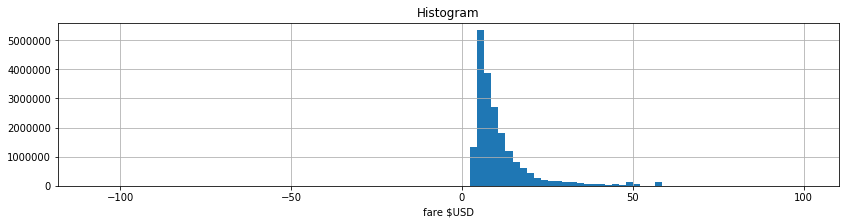

In [32]:
# plot histogram of fare
train_df[train_df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In [33]:
#check for missing values in train data
train_df.isnull().sum().sort_values(ascending = False)

dropoff_latitude     139
dropoff_longitude    139
passenger_count        0
pickup_latitude        0
pickup_longitude       0
pickup_datetime        0
fare_amount            0
key                    0
dtype: int64

In [34]:
#check for missing values in test data
train_df = train_df.dropna()
train_df.isnull().sum().sort_values(ascending = False)

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
fare_amount          0
key                  0
dtype: int64

In [35]:
df_test = pd.read_csv('/Users/hthakkar/Desktop/fare_price_preds/test.csv')
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [36]:
df_test.describe().round(1)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.0,9914.0,9914.0,9914.0,9914.0
mean,-74.0,40.8,-74.0,40.8,1.7
std,0.0,0.0,0.0,0.0,1.3
min,-74.3,40.6,-74.3,40.6,1.0
25%,-74.0,40.7,-74.0,40.7,1.0
50%,-74.0,40.8,-74.0,40.8,1.0
75%,-74.0,40.8,-74.0,40.8,2.0
max,-73.0,41.7,-73.0,41.7,6.0


In [37]:
# minimum and maximum longitude test set
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [38]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [39]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [40]:
print('Old size: %d' % len(train_df))
train_df = train_df[select_within_boundingbox(train_df, BB)]
print('New size: %d' % len(train_df))

Old size: 19999861
New size: 19575814


In [41]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

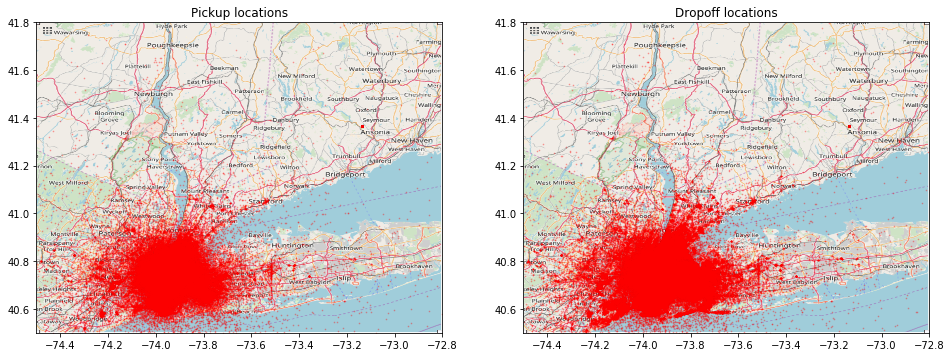

In [42]:
# plot training data on map
plot_on_map(train_df, BB, nyc_map, s=0.5, alpha=0.3)

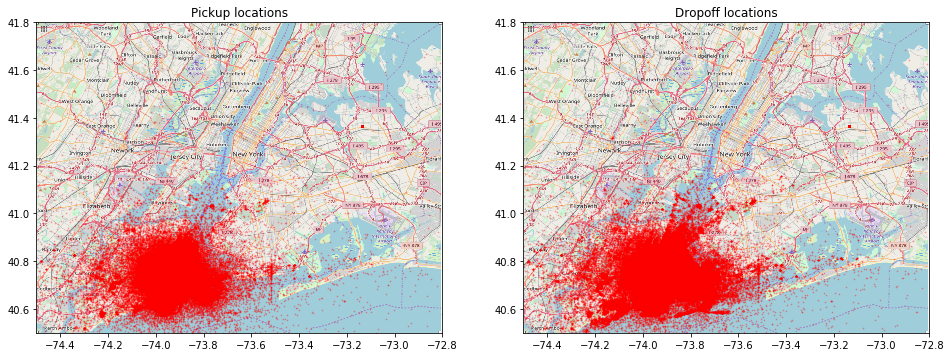

In [43]:
# plot training data on zoomed map
plot_on_map(train_df, BB, nyc_map_zoom, s=0.5, alpha=0.3)

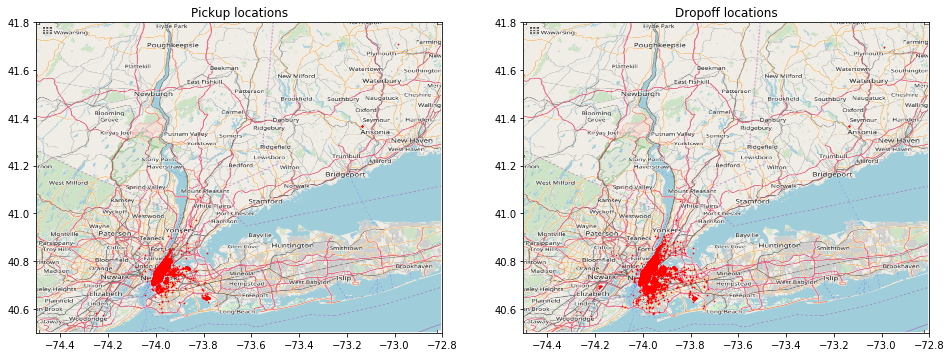

In [44]:
# plot test data on map
plot_on_map(df_test, BB, nyc_map, alpha=1.0, s=0.5)

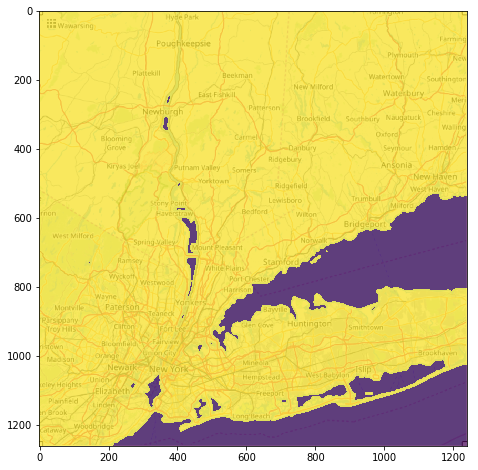

In [45]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in yellow, False in purple.

In [46]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [47]:
pickup_x, pickup_y = lonlat_to_xy(train_df.pickup_longitude, train_df.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(train_df.dropoff_longitude, train_df.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [48]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 4045


In [49]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [50]:
print('Old size: %d' % len(train_df))
train_df = remove_datapoints_from_water(train_df)
print('New size: %d' % len(train_df))

Old size: 19575814
New size: 19571769


In [51]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [52]:
train_df.shape

(19571769, 8)

Let's create two new features in our training set representing the "travel vector" between the start and end points of the taxi ride, in both longitude and latitude coordinates.  We'll take the absolute value since we're only interested in distance traveled. Use a helper function since we'll want to do the same thing for the test set later.

In [53]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

In [54]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754


In [55]:
import datetime as dt

train_df['Year'] = train_df['pickup_datetime'].dt.year
train_df['Month'] = train_df['pickup_datetime'].dt.month
train_df['Date'] = train_df['pickup_datetime'].dt.day
train_df['Day_of_Week'] = train_df['pickup_datetime'].dt.dayofweek
train_df['Hour'] = train_df['pickup_datetime'].dt.hour
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,Year,Month,Date,Day_of_Week,Hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,2009,6,15,0,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,2010,1,5,1,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,2011,8,18,3,0
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2010,3,9,1,7


### Exploratory Data Analysis

Now let's quickly plot a subset of our travel vector features to see its distribution.

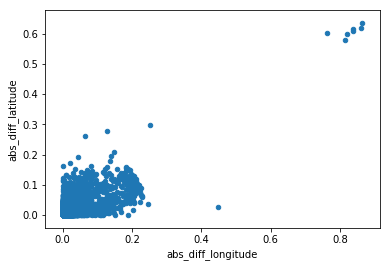

In [56]:
plot = train_df.iloc[:10000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city.  For reference, one degree of latitude is about 69 miles.  However, we can see the dataset has extreme values which do not make sense.  Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5 (though remember the scatterplot is only showing the first 10,000 rows...)

In [57]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 19571769
New size: 19571769


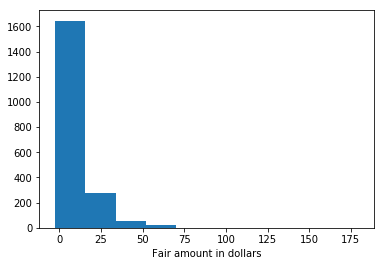

In [58]:
#analyzing the distribution of `Fair amount`
plt.hist(train_df['fare_amount'][:2000])

plt.xlabel('Fair amount in dollars')
plt.show()

The fair price distribution looks Right-skewed with majority of rides having price between dollars 2 and 20. Let's see if pickup datetime has any correlation with the fair price.  

### Train our model
First let's setup our input matrix $X$ and target column $y$ from our data.  The matrix $X$ should consist of the features that are significant in predicting the output which is Fair Price. The column $y$ should consist of the target `fare_amount` values.

In [59]:
train_df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'abs_diff_longitude', 'abs_diff_latitude', 'Year',
       'Month', 'Date', 'Day_of_Week', 'Hour'],
      dtype='object')

In [60]:
#Write a function to get the columns that we want to include in our X matrix as we would be doing the same with our test set.
def get_input_matrix(df):
    return np.column_stack((df.pickup_longitude, df.abs_diff_longitude, df.abs_diff_latitude, 
                            df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude, 
                            df.Hour, df.Day_of_Week, df.Month, df.Year))

X = get_input_matrix(train_df)
Y = np.array(train_df['fare_amount'])

print(X.shape)
print(Y.shape)

(19571769, 10)
(19571769,)


In [61]:
#Divide our data into train and validation set. We will be using validation set to tune the hyperparameters of the model. 
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = 0.0005, random_state=0)

print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(19561983, 10)
(9786, 10)
(19561983,)
(9786,)


In [62]:
# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [1]
for learning_rate in learning_rates:
    gb = GradientBoostingRegressor(n_estimators = 10, learning_rate = learning_rate, max_depth = 6, random_state = 0)
    gb.fit(X_train, Y_train)
    pred_train = gb.predict(X_train)
    pred_validation = gb.predict(X_validation)
    print("Learning rate: ", learning_rate)
    print("RMSE (training): {0:.3f}".format(np.sqrt(mean_squared_error(Y_train, pred_train))))
    print("RMSE (validation): {0:.3f}".format(np.sqrt(mean_squared_error(Y_validation, pred_validation))))
    print()

Learning rate:  1
RMSE (training): 3.936
RMSE (validation): 3.744



In [63]:
# #Let's use the learning rate as 0.1 which works best for our model from the RSME on our validation set above
# gb = GradientBoostingRegressor(n_estimators = 10, learning_rate = 0.1, max_depth = 6, random_state = 0)
# gb.fit(X_train, Y_train)

In [64]:
#let's see what are the significant features in predicting our output
gb.feature_importances_

array([0.08056446, 0.22274662, 0.17464696, 0.05852664, 0.15076875,
       0.17786001, 0.05062348, 0.01463385, 0.0158548 , 0.05377444])

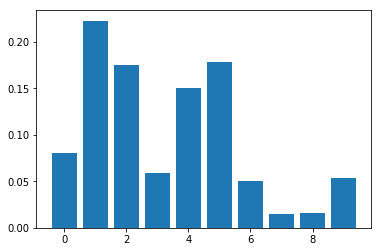

In [65]:
plt.bar(range(len(gb.feature_importances_)), gb.feature_importances_)
plt.show()

### Make predictions on the test set
Now let's load up our test inputs and predict the `fare_amount`s for them using our learned weights!

In [66]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(df_test)
df_test['key'] = pd.to_datetime(df_test['key'], format= '%Y/%m/%d %H:%M:%S', exact= True)
df_test['pickup_datetime']  = df_test.pickup_datetime.str[:20]
df_test['pickup_datetime']  = pd.to_datetime(df_test['pickup_datetime'], format = '%Y/%m/%d %H:%M:%S')

df_test['Year'] = df_test['pickup_datetime'].dt.year
df_test['Month'] = df_test['pickup_datetime'].dt.month
df_test['Date'] = df_test['pickup_datetime'].dt.day
df_test['Day_of_Week'] = df_test['pickup_datetime'].dt.dayofweek
df_test['Hour'] = df_test['pickup_datetime'].dt.hour
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,Year,Month,Date,Day_of_Week,Hour
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,2015,1,27,1,13
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,2015,1,27,1,13
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,2011,10,8,5,11
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,2012,12,1,5,21
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,2012,12,1,5,21


In [67]:
test_X = get_input_matrix(df_test)
test_y_predictions = gb.predict(test_X)

In [68]:
ss = pd.read_csv('/Users/hthakkar/Desktop/fare_price_preds/sample_submission.csv')
ss.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [69]:
ss.loc[:, 'fare_amount'] = test_y_predictions
ss.to_csv('9_12_3.csv', index=False)

## Ideas for Improvement
The output here will score an RMSE of $3.35, which shows that our model has a high bias, but we can do better than that!  Here are some suggestions:

* Try training bigger model, train longer, or try using a Neural Network architecture.
* Use absolute location data rather than relative.  Here we're only looking at the difference between the start and end points, but maybe the actual values -- indicating where in NYC the taxi is traveling -- would be useful.
* Try to find more outliers to prune, or construct useful feature crosses.
* Use the entire dataset -- here we're only using about 60% of the training data!